## Extracting a Country's inner-coordinates
Continuing from the last Notebook - **Country's bounded-Coordinates to Polygon-Objects**, we will now collect all latitude-longitude points within a country that cover it's full geometric-shape. (coordinates evenly-spaced by 3 decimals or 0.001)

Test Country: **United Arab Emirates**

Sneak-peak of our DF's middle 4 rows:


,iso_a3,polytype,geo
country,,,
South Korea,KOR,MultiPolygon,(POLYGON ((126.8233663710002 33.55943982600012...
Kosovo,-99,Polygon,"POLYGON ((20.86470015400005 43.21733734200004,..."
Kuwait,KWT,MultiPolygon,(POLYGON ((48.38111412900017 29.43398672100004...
Laos,LAO,Polygon,"POLYGON ((101.8679211830001 22.37884185800007,..."


Testing with -> United Arab Emirates:


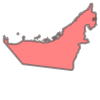

In [1]:
import numpy as np

# Loading the last saved dataframe 
geo_df = np.load('countries_geo.npy', allow_pickle=True).item()['df']
nrows = geo_df.shape[0]

UAE = geo_df.loc['United Arab Emirates']

print("Sneak-peak of our DF's middle 4 rows:")
display(geo_df.iloc[nrows//2 - 2 : nrows//2 + 2])

print(f"Testing with -> {UAE.name}:")
UAE.geo

Using the *bounds* of our country, we can generate a **square-boundary**/box around the country's shape to help extract the inner-coordinates.

(<u>bounds</u>: minimum and maximum latitudes and longitudes (y and x) of our country's border)

In [2]:
minlng, minlat, maxlng, maxlat = UAE.geo.bounds

minmax_lats, minmax_lngs = [minlat, maxlat], [minlng, maxlng]
UAE_square_corners = [(x,y) for x in minmax_lats for y in minmax_lngs]

print(f"{UAE.name}'s Square-boundary corners:")
UAE_square_corners

United Arab Emirates's Square-boundary corners:


[(22.62094594300011, 51.56934655000006),
 (22.62094594300011, 56.383636915000096),
 (26.074791972000142, 51.56934655000006),
 (26.074791972000142, 56.383636915000096)]

### Plotting a country and it's Square-boundary box
Using <u>Matplotlib</u>, lets visualize one approach of extracting our country's inner-coordinates: 

Extract points within the square-boundary box (**BLUE**) that lie within the country (in **GREEN**).

United Arab Emirates's:
square-box (BLUE) and Geo-shape (GREEN)



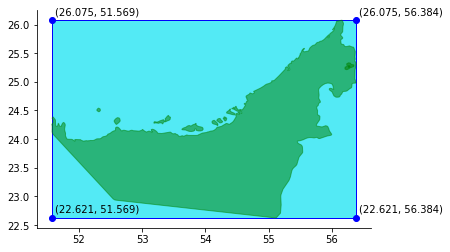

In [3]:
from matplotlib import patches, pyplot as plt, path as mpath

# Rectangle made by UAE's Square-boundary coordinates
UAE_square = patches.Rectangle((minlng, minlat), #(left, bottom)
                                maxlng - minlng, #(width)
                                maxlat - minlat, #(height)
                                fc = "#53eaf5",  # Face color
                                ec = 'blue',     # Edge color 
                               )
# Making the main plot
fig, axes = plt.subplots()
axes.add_patch(UAE_square) # Add UAE's Box/Square in the plot first

# Add UAE's Geo-shape in the plot (overlay over UAE-Box)
UAE_land_borders = []
for i, geom in enumerate(UAE.geo.geoms, 1):    
    # x = Longitude, y = Latitude
    lngs_arr, lats_arr = geom.exterior.xy

    # Make Polygon-patches (plot-shapes) from UAE's Polygons/Lands:
    land_border_coords = list(map(list, zip(lngs_arr, lats_arr))) # Concatenate Lats & Longs
    land_patch = patches.Polygon(land_border_coords, color="green", alpha=0.5)
    
    # OR the easier way is to "fill" Polygons/Lands into the plot as:
    # axs.fill(lngs_arr, lats_arr, alpha=0.5, fc='green', ec='blue')
    
    axes.add_patch(land_patch) # Add the Polygons/Lands to the Plot
    UAE_land_borders.append(land_border_coords) # Collect border-coordinates per Polygon

# Label the corners of UAE's Square/box
for lat, lng in UAE_square_corners:
#     plt.annotate(f'{round(lat,3), round(lng,3)}', xy=(lng, lat))
    axes.plot(lng, lat, 'bo')
    axes.text(lng+.05, lat+.1, f'{round(lat,3), round(lng,3)}')

# Remove the plot's frame-outlines
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)
    
print(f"{UAE.name}'s:\n"+
      "square-box (BLUE) and Geo-shape (GREEN)\n")
plt.show()

From the plot, we can assume the country's geo-shape makes up atmost half of the Blue-box's area.

To see **how many of the Blue-box's coordinates** (lets call them **box-points**) would be checked for being inside the country (within it's boundary), lets generate *evenly-spaced* coordinates within the box (coordinates with gaps of 0.001)

In [4]:
from ttictoc import tic, toc # Time-tracker

# Making a range of latitudes and longitudes (min to max) 
# that are evenly-spaced by 0.001 (gaps between each point)
square_lats = np.arange(*minmax_lats, 0.001)
square_lngs = np.arange(*minmax_lngs, 0.001)

tic() #--- Start Time
# Combinations of latitudes and longitudes (lying inside the Blue-box)
UAE_square_coords = np.array(np.meshgrid(square_lngs, square_lats)).T.reshape(-1, 2)

print(f"The Blue-box/UAE's square-boundary contains {len(UAE_square_coords):,} coordinates (with gaps of 0.001)")
print(f"(Time taken to generate coordinates: {round(toc(), 3)} seconds)") # -- End Time
print("\nThe coordinates in [longitude, latitude] form:")
UAE_square_coords

The Blue-box/UAE's square-boundary contains 16,631,010 coordinates (with gaps of 0.001)
(Time taken to generate coordinates: 0.884 seconds)

The coordinates in [longitude, latitude] form:


array([[51.56934655, 22.62094594],
       [51.56934655, 22.62194594],
       [51.56934655, 22.62294594],
       ...,
       [56.38334655, 26.07194594],
       [56.38334655, 26.07294594],
       [56.38334655, 26.07394594]])

Around **~16.5 million coordinates lie inside the Blue-box**! Our approach of checking for box-points within the country's boundaries can have **heavy, time-consuming computations** (indeed, since I have tested this approach). 

---
### Coordinates within the Country as a single Polygon
A better approach can be to minimize the Blue-box's size, or use a Polygon with a shape as close to our country's geo-shape, to avoid mismatching millions of useless box-points.

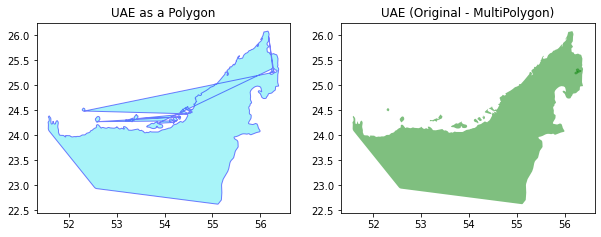

In [5]:
# Flattening all of UAE's Polygon-layers to a single Polygon of coordinates:
UAE_Polygon_coords = sum(UAE_land_borders, []) # Flattened
UAE_polyLngs, UAE_polyLats = zip(*UAE_Polygon_coords)

UAE_polygon = patches.Polygon(np.array(UAE_Polygon_coords), 
                             fc='#53eaf5', ec='blue',
                              alpha=0.5)

fig, axs = plt.subplots(ncols=2, figsize=(10,3.5))

# Plot-1: UAE as a single Polygon (in BLUE)
axs[0].fill(UAE_polyLngs, UAE_polyLats, alpha=0.5, fc='#53eaf5', ec='blue')
axs[0].set_title('UAE as a Polygon')

# Plot-2: UAE as it's original Geo-shape (MultiPolygon)
for i, geom in enumerate(UAE.geo.geoms, 1):    
    
    lngs_arr, lats_arr = geom.exterior.xy
    axs[1].fill(lngs_arr, lats_arr, alpha=0.5, fc='green')

axs[1].set_title('UAE (Original - MultiPolygon)')

plt.show()

Putting the two plots together:

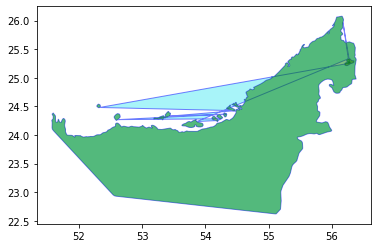

In [6]:
fig, axs = plt.subplots()
axs.add_patch(UAE_polygon)

for i, geom in enumerate(UAE.geo.geoms, 1):    
    lngs_arr, lats_arr = geom.exterior.xy
    axs.fill(lngs_arr, lats_arr, alpha=0.5, fc='green')

plt.show()

The Country's single Polygon almost matches it's full geo-shape (one of the Polygons makes up most of the country). Lets use the inner-coordinates of our old Blue-box to extract out coordnates within our country's Polygon.

### Extract Country-Polygon's inner-Coordinates

In [7]:
tic() # --- Start Time
coords_in_UAE_polygon = UAE_polygon.contains_points(
                        axs.transData.transform(UAE_square_coords))

print(f"Total of {coords_in_UAE_polygon.sum():,} (box-points) found within UAE's Polygon-shape")
print(f'Time taken: {round(toc(),3)} seconds...') # --- End Time

Total of 6,590,096 (box-points) found within UAE's Polygon-shape
Time taken: 116.637 seconds...


In [8]:
UAE_polygon_coords = UAE_square_coords[np.where(coords_in_UAE_polygon)]

print("These coordinates lie within our country's Polygon:")
UAE_polygon_coords

These coordinates lie within our country's Polygon:


array([[51.57834655, 24.25094594],
       [51.57834655, 24.25194594],
       [51.57834655, 24.25294594],
       ...,
       [56.37534655, 25.31494594],
       [56.37534655, 25.31594594],
       [56.37534655, 25.31694594]])

### A function for converting bounds to square-coordinates
A little function I thought may be handy in the future for converting some xy-bounds to square-coordinates and more. 

In [9]:
def square_coords(bounds, by_y=False, inner = 0.001):
    import numpy as np
    
    minmax_yx = []
    square_corners = []
    for x in bounds:
        for y in bounds:
            if x != y: 
                xy = [x,y]
#                 if len(set(xy)) < 4:
                    
                if by_y:
                    xy = sorted(xy)
                
                if str(x)[0] != str(y)[0]:
                    square_corners.append(xy)
                else:
                    minmax_yx.append(xy)
    
    minmax_y, minmax_x = sorted(minmax_yx)[::2]
    
    results = {'corners': sorted(square_corners)[::2], 
               'minmax': {'lat':minmax_y, 'lng':minmax_x}}
    
    if inner and inner != 0: # inner = False -> don't make inner-coordinates
        square_ys = np.arange(*minmax_y, inner)
        square_xs = np.arange(*minmax_x, inner)
        xy_combos = len(square_ys)*len(square_xs)

        if xy_combos > 16000000:
            print(f'Generating {xy_combos:,} xy-points, slow process taking place...\n')

        results['coords'] = np.array(np.meshgrid(square_ys, square_xs)).T.reshape(-1, 2)
    
    return results

# ============== Test Function ==============
random_4nums = [10, 17, 20, 27]
my_square = square_coords(random_4nums)

my_square

Generating 49,000,000 xy-points, slow process taking place...



{'corners': [[10, 20], [17, 20], [20, 10], [27, 10]],
 'minmax': {'lat': [10, 17], 'lng': [20, 27]},
 'coords': array([[10.   , 20.   ],
        [10.   , 20.001],
        [10.   , 20.002],
        ...,
        [16.999, 26.997],
        [16.999, 26.998],
        [16.999, 26.999]])}